<a href="https://colab.research.google.com/github/jimmyjamesarnold/notebooks/blob/master/RandomWalks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

In [0]:
# read clinical data from local folder
os.chdir('D:\Metabolic Modeling\PanCanTSM\PanCanTSM\clinicalFeatures\TCGA_Clinical_data')
clin_df = pd.read_csv('clin.merged_BRCA.txt', sep='\t',index_col=0)
clin_df = clin_df.transpose()
clin_df.index = clin_df.patient_bcr_patient_barcode

# read in flux data
os.chdir('D:\Metabolic Modeling\PanCanTSM\PanCanTSM\models')
flux_df = pd.read_csv('TCGA_medianFluxes.csv',index_col=0)
flux_df = flux_df.transpose()
flux_df.index = flux_df.index.str.lower()
flux_df.index = flux_df.index.str.replace('_','-')

# reciprocate
BRCA_clin = clin_df.loc[clin_df.index.intersection(flux_df.index.tolist())].sort_index()

C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (27,227,230,234,252,254,257,261,267,270,271,273,275,281,283,288,289,290,295) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
BRCA_clin

admin_batch_number,admin_bcr,admin_day_of_dcc_upload,admin_disease_code,admin_file_uuid,admin_month_of_dcc_upload,admin_patient_withdrawal_withdrawn,admin_project_code,admin_year_of_dcc_upload,patient_additional_studies,patient_additional_studies_additional_study_disease_code,...,patient_tumor_samples_tumor_sample_tumor_locations_tumor_location-3_site_of_disease,patient_tumor_samples_tumor_sample_tumor_locations_tumor_location-3_site_of_disease_description,patient_tumor_samples_tumor_sample_tumor_locations_tumor_location-3_site_of_disease_text,patient_tumor_samples_tumor_sample_tumor_locations_tumor_location_site_of_disease,patient_tumor_samples_tumor_sample_tumor_locations_tumor_location_site_of_disease_description,patient_tumor_samples_tumor_sample_tumor_locations_tumor_location_site_of_disease_text,patient_tumor_samples_tumor_sample_tumor_necrosis_percent,patient_tumor_samples_tumor_sample_tumor_nuclei_percent,patient_tumor_samples_tumor_sample_tumor_weight,patient_tumor_samples_tumor_sample_vessel_used
tcga-3c-aalk,nationwide children's hospital,21,brca,9c547d5e-0688-4940-9329-a6f3469930c0,1,FALSE,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,breast,NaN,NaN,2,80,150,cryomold
tcga-5l-aat0,nationwide children's hospital,21,brca,4f359141-a351-40ac-a30a-4c27702fa01d,1,FALSE,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,breast,NaN,NaN,0,90,100,cryovial
tcga-a1-a0sb,nationwide children's hospital,21,brca,bcb8bb68-8981-46fd-a45f-fa31ea6ddda1,1,FALSE,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,breast,NaN,NaN,0,85,500,cassette
tcga-a1-a0sd,nationwide children's hospital,21,brca,6cef6ecd-264e-4df6-8419-9e4c564da7b2,1,FALSE,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,breast,NaN,NaN,0,70,500,cassette
tcga-a1-a0sg,nationwide children's hospital,21,brca,86c19c0d-2707-405f-a74a-fd0c2f1beb30,1,FALSE,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,breast,NaN,NaN,0,90,500,cassette
tcga-a1-a0sh,nationwide children's hospital,21,brca,b3d016c1-ee26-47d2-99d8-79f9b63a2bb0,1,FALSE,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,breast,NaN,NaN,0,75,500,cassette
tcga-a1-a0sq,nationwide children's hospital,21,brca,ab1c47ab-7c0b-43e5-b9a8-9e97a2d7f486,1,FALSE,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,breast,NaN,NaN,1,90,500,cassette
tcga-a2-a04p,nationwide children's hospital,21,brca,11760e40-8879-471d-884c-923d97a46ed2,1,FALSE,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,breast,NaN,NaN,0,90,276,cryomold
tcga-a2-a04r,nationwide children's hospital,21,brca,be84bc56-0cf5-4243-a2e0-02381cf71199,1,FALSE,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,breast,NaN,NaN,0,85,210,cryomold
tcga-a2-a04t,nationwide children's hospital,21,brca,8ad98c2d-6a28-4054-be48-74bd7fca92dc,1,FALSE,tcga,2016,NaN,NaN,...,NaN,NaN,NaN,breast,NaN,NaN,0,90,260,cryomold


In [0]:
# Preprocessing Steps
# 1 - filter only black and white samples
# 2 - scale (MaxAbsScale) fluxes
# 3 - select fluxes via Variance Threshold, remove 0s
# 4 - select fluxes based on L1 penalization - this can be optimized
# 5 - try different classification algorithms
# 6 - score using roc_auc
# 7 - goal is at least .80
# 8 - retrieve most important features, generate boxplots of those features by race in original data

In [0]:
# 1 - filter only black and white samples
clin_df_BW = clin_df[clin_df['patient_race_list_race'].isin(['black or african american', 'white'])]
# filter for presence in flux data
clin_df_BW = clin_df_BW.loc[clin_df_BW.index.intersection(flux_df.index.tolist())].sort_index()

C:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


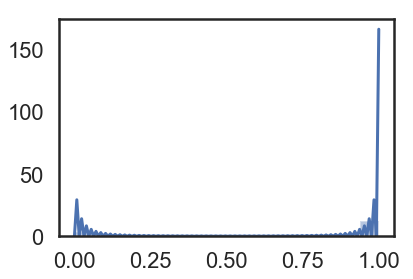

In [0]:
# convert race to labels for sklearn
le = preprocessing.LabelEncoder()
y = le.fit_transform(clin_df_BW.patient_race_list_race.tolist())
# check label classes
list(le.classes_)
sns.distplot(y)

In [0]:
len(y)

278

In [0]:
# apply to flux_df
BRCA_flux = flux_df.loc[flux_df.index.intersection(clin_df_BW.index.tolist())].sort_index()
# replace missing fluxes with 0s ... fair b/c they were excluded from the model on basis of GeneEx
X = BRCA_flux.fillna(0)
X.shape

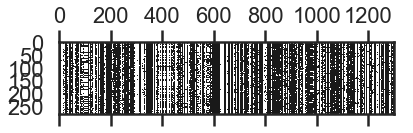

In [0]:
# visualize sparsity
plt.spy(X)

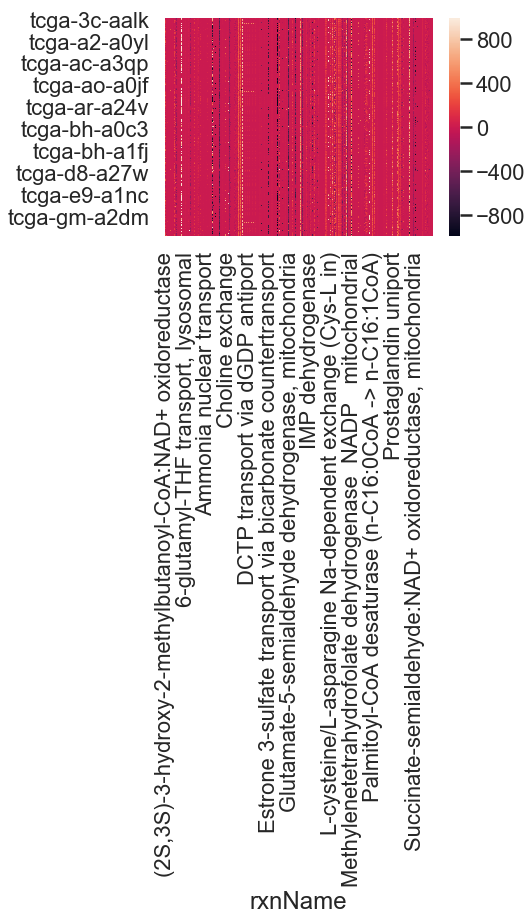

In [0]:
ax = sns.heatmap(X)

In [0]:
# 2 - Use MaxAbsScale to scale fluxes - retains same column names
# scales data around 0
from sklearn.preprocessing import MaxAbsScaler
transformer = MaxAbsScaler().fit(X)
X_scale = transformer.transform(X)
X_scale = pd.DataFrame(data = X_scale)
X_scale.columns = X.columns

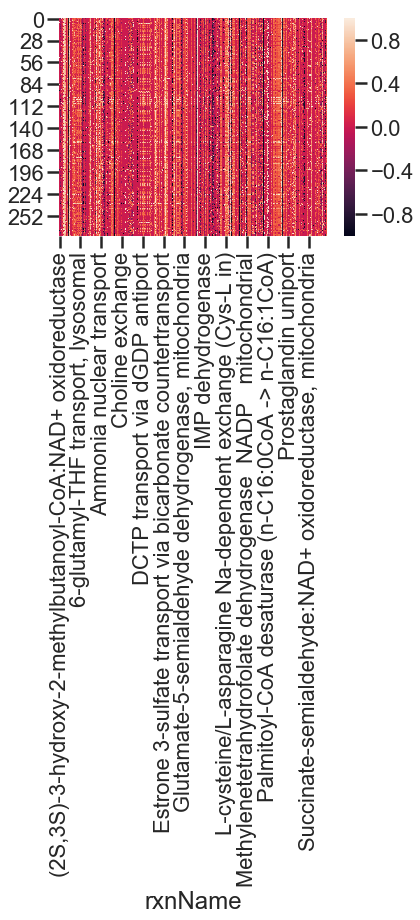

In [0]:
ax = sns.heatmap(X_scale)

In [0]:
# 2 - drop 0 variance rows
from sklearn.feature_selection import VarianceThreshold
def variance_threshold_selector(data, threshold=0.0):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

X_select = variance_threshold_selector(X_scale)
X_select.shape

(278, 1240)

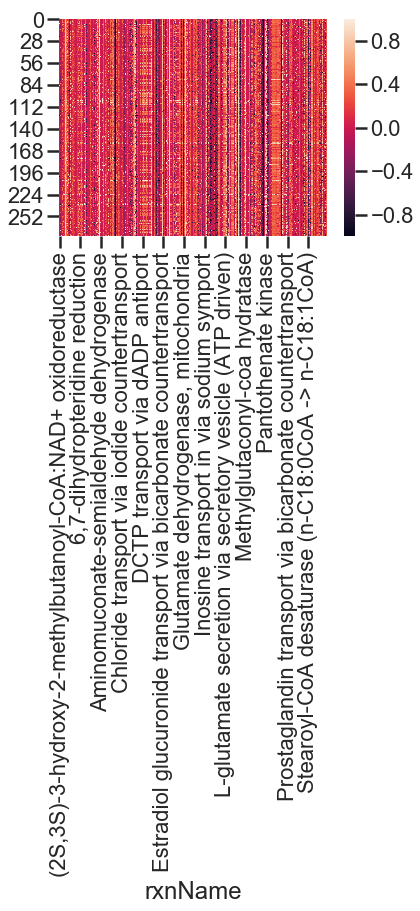

In [0]:
ax = sns.heatmap(X_select)

In [0]:
# trying penalization with L1 norm
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=10, penalty="l1", dual=False, random_state=42).fit(X_select, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_select)
X_new.shape

(278, 218)

In [0]:
features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
features = [column for column in data[features]] #Array of all nonremoved features' names

#Format and Return
selector = pd.DataFrame(selector.transform(data))
selector.columns = features
return selector

In [0]:
def feature_selector(data):
    lsvc = LinearSVC(C=10, penalty="l1", dual=False, random_state=42).fit(X_select, y)
    model = SelectFromModel(lsvc, prefit=True)
    return data[data.columns[model.get_support(indices=True)]]

X_new = feature_selector(X_select)

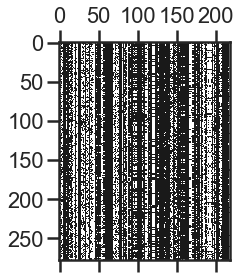

In [0]:
# visualize sparsity
plt.spy(X_new)

In [0]:
# Tune Linear SVC hyperparamters
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}]
#{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [0.01, 0.1, 1, 10, 100, 1000]}
                     

clf = GridSearchCV(SVC(random_state=42), tuned_parameters, cv=5, scoring='roc_auc')

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
y_true, y_pred = y_test, clf.predict(X_test)
print(roc_auc_score(y_true, y_pred))

Best parameters set found on development set:
{'C': 10, 'kernel': 'linear'}
Grid scores on development set:

0.837 (+/-0.132) for {'C': 0.01, 'kernel': 'linear'}
0.862 (+/-0.100) for {'C': 0.1, 'kernel': 'linear'}
0.890 (+/-0.096) for {'C': 1, 'kernel': 'linear'}
0.893 (+/-0.096) for {'C': 10, 'kernel': 'linear'}
0.893 (+/-0.096) for {'C': 100, 'kernel': 'linear'}
0.893 (+/-0.096) for {'C': 1000, 'kernel': 'linear'}
0.8646464646464646


In [0]:
# Run optimized model
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
clf = SVC(C = 10, kernel = 'linear', random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)
roc_auc_score(y_true, y_pred)

0.8646464646464646

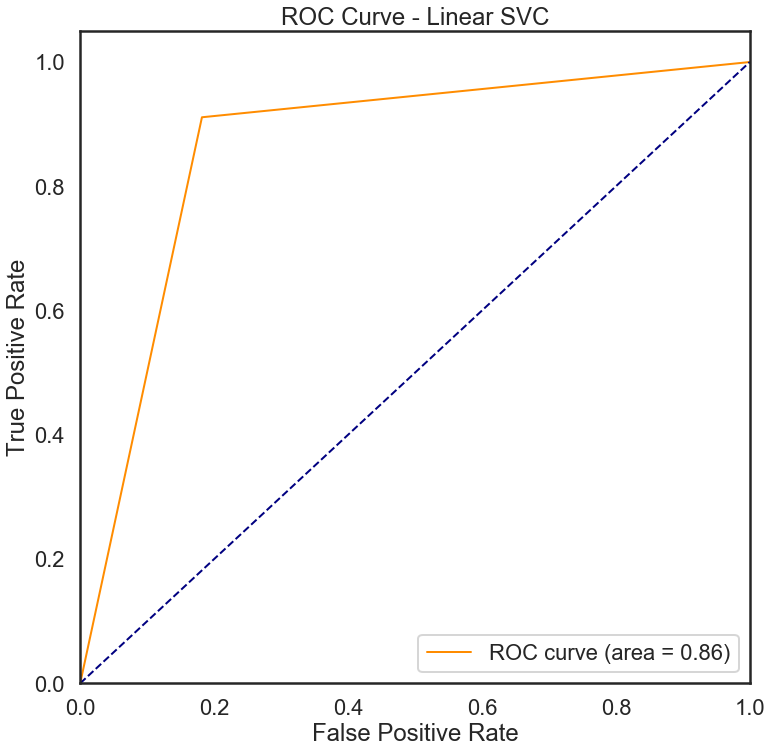

In [0]:
# plot ROC Curve
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred,title='something'):
    """
    This function plots the ROC Curve.
    """
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    sns.set(context = 'poster',
           style = 'white')

    # Plot of a ROC curve for a specific class
    plt.figure(figsize = (12,12))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc_curve(y_true, y_pred, title = 'ROC Curve - Linear SVC')

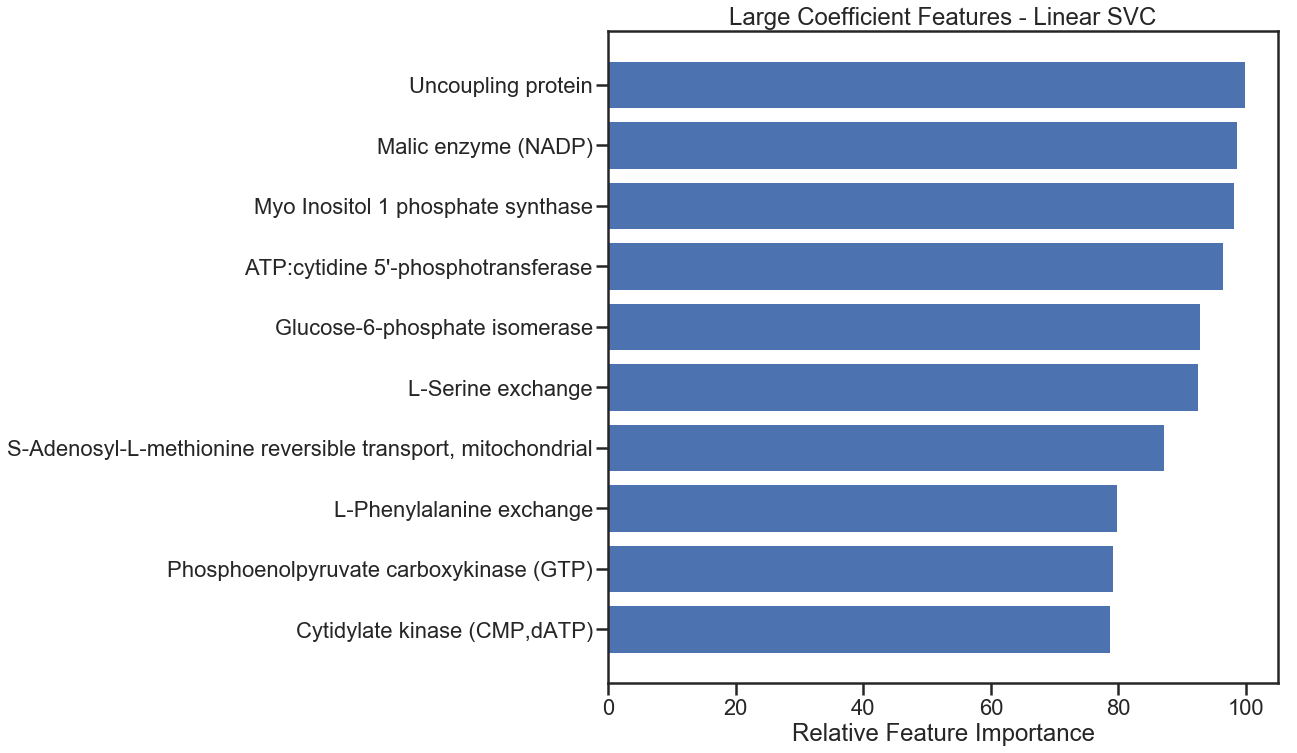

In [0]:
# get top 10 relative feature importances
def plot_top_features(feature_importance, title = 'something'):
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(10) + .5

    sns.set(context = 'poster', style = 'ticks')
    plt.figure(figsize=(12,12))
    plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
    plt.yticks(pos,np.array(X_new.columns)[sorted_idx][-10:] )
    plt.xlabel('Relative Feature Importance')
    plt.title(title)
    plt.show()

# get top 10 relative feature importances
feature_importance = abs(clf.coef_[0])
plot_top_features(feature_importance, title = 'Large Coefficient Features - Linear SVC')

In [0]:
# Get feature importances and write to table
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

d = {'feature_name': np.array(X_new.columns)[sorted_idx], 'feature_importance': feature_importance[sorted_idx]}
df = pd.DataFrame(data=d)
df.to_csv('Feature_Importance_BRCA_LinearSVC.csv')

Normalized confusion matrix
[[0.82 0.18]
 [0.09 0.91]]


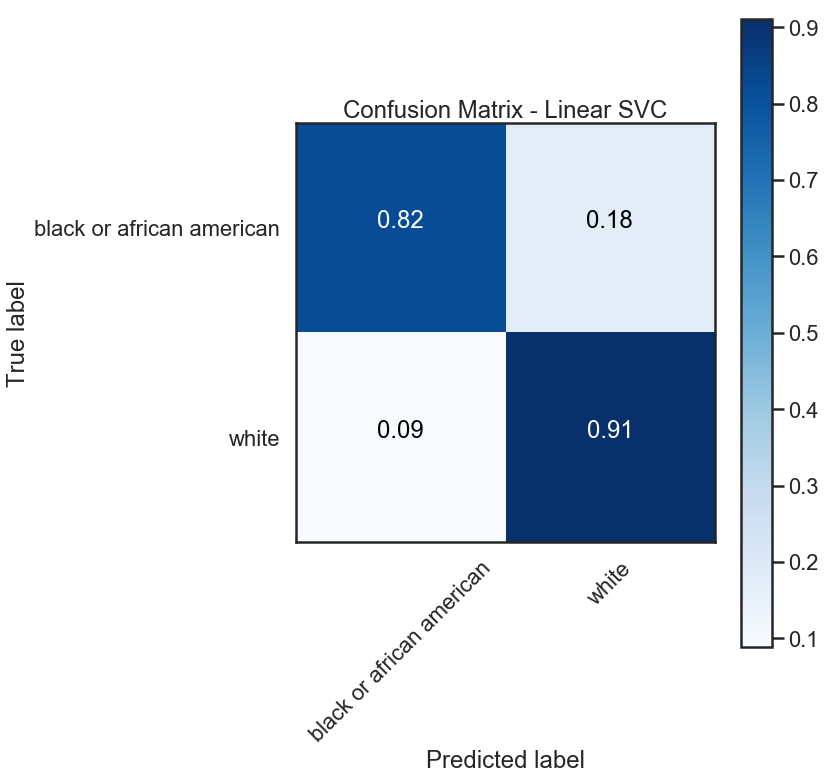

In [0]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
sns.set(context = 'poster',
       style = 'white')
plt.figure(figsize = (12,12))
plot_confusion_matrix(cnf_matrix, classes=le.classes_,normalize=True,
                      title='Confusion Matrix - Linear SVC')

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

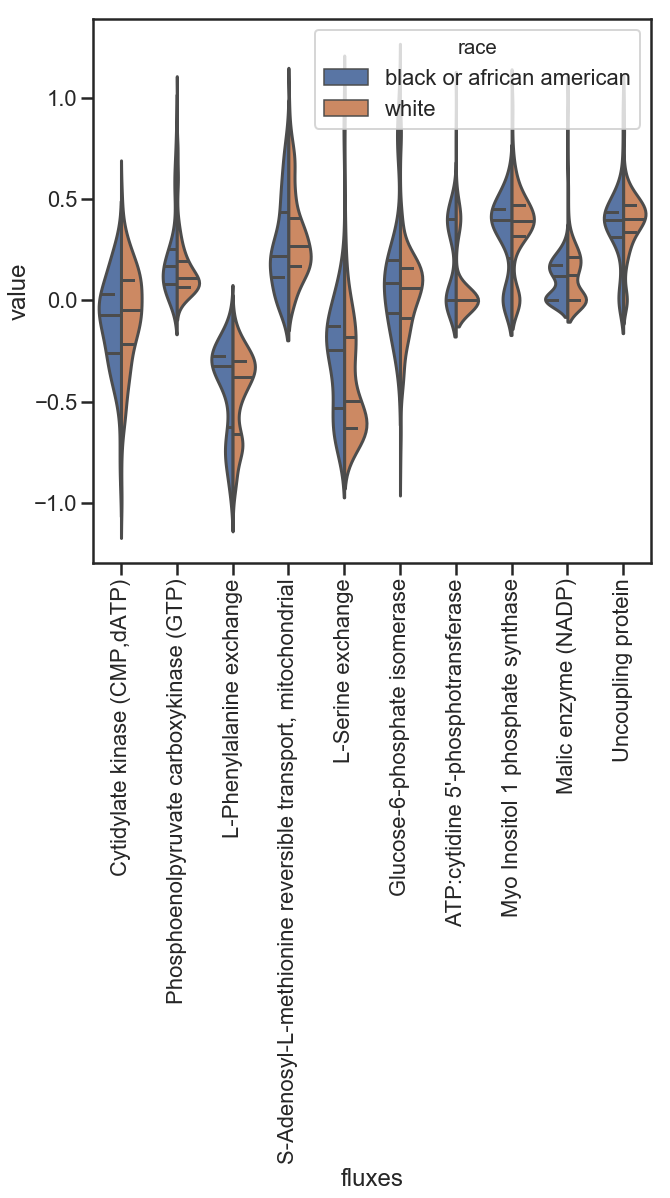

In [0]:
# compare top 10 most important features between groups
top_feat = X_new[X_new.columns[sorted_idx][-10:]]
top_feat['race'] = clin_df_BW.patient_race_list_race.tolist()

# melt top features into long form dataframe
data = pd.melt(top_feat,id_vars='race',
                    var_name="fluxes",
                    value_name='value')

# make violin plots
plt.figure(figsize=(10,10))
sns.violinplot(x="fluxes", y="value", hue="race", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

In [0]:
# Tune log reg
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'penalty':['l1', 'l2'], 
                   'C':np.logspace(-2, 7, 10)}

clf = GridSearchCV(LogisticRegression(random_state=42), tuned_parameters, cv=5, scoring='roc_auc')

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.4, random_state=42)

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
y_true, y_pred = y_test, clf.predict(X_test)
print(roc_auc_score(y_true, y_pred))

Best parameters set found on development set:
{'C': 100000.0, 'penalty': 'l2'}
Grid scores on development set:

0.500 (+/-0.000) for {'C': 0.01, 'penalty': 'l1'}
0.759 (+/-0.178) for {'C': 0.01, 'penalty': 'l2'}
0.480 (+/-0.079) for {'C': 0.1, 'penalty': 'l1'}
0.841 (+/-0.158) for {'C': 0.1, 'penalty': 'l2'}
0.738 (+/-0.159) for {'C': 1.0, 'penalty': 'l1'}
0.861 (+/-0.151) for {'C': 1.0, 'penalty': 'l2'}
0.778 (+/-0.212) for {'C': 10.0, 'penalty': 'l1'}
0.862 (+/-0.139) for {'C': 10.0, 'penalty': 'l2'}
0.781 (+/-0.197) for {'C': 100.0, 'penalty': 'l1'}
0.865 (+/-0.129) for {'C': 100.0, 'penalty': 'l2'}
0.774 (+/-0.205) for {'C': 1000.0, 'penalty': 'l1'}
0.867 (+/-0.118) for {'C': 1000.0, 'penalty': 'l2'}
0.845 (+/-0.092) for {'C': 10000.0, 'penalty': 'l1'}
0.867 (+/-0.127) for {'C': 10000.0, 'penalty': 'l2'}
0.854 (+/-0.081) for {'C': 100000.0, 'penalty': 'l1'}
0.868 (+/-0.126) for {'C': 100000.0, 'penalty': 'l2'}
0.857 (+/-0.089) for {'C': 1000000.0, 'penalty': 'l1'}
0.867 (+/-0.128) 

In [0]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C = 100000.0, penalty = 'l2', random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.4, random_state=42)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)
roc_auc_score(y_true, y_pred)

0.7208109428431853

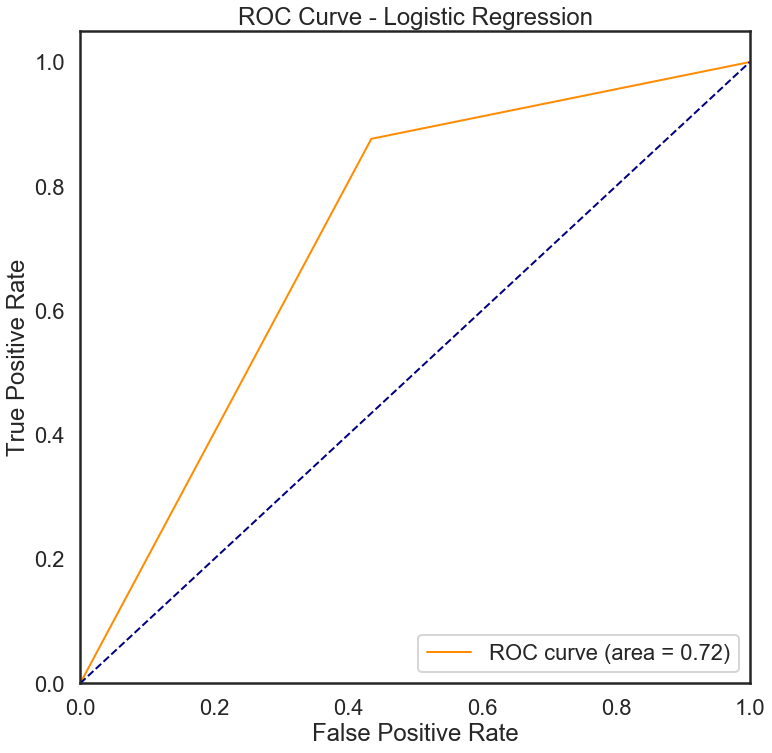

In [0]:
# plot ROC
plot_roc_curve(y_true, y_pred, title = 'ROC Curve - Logistic Regression')

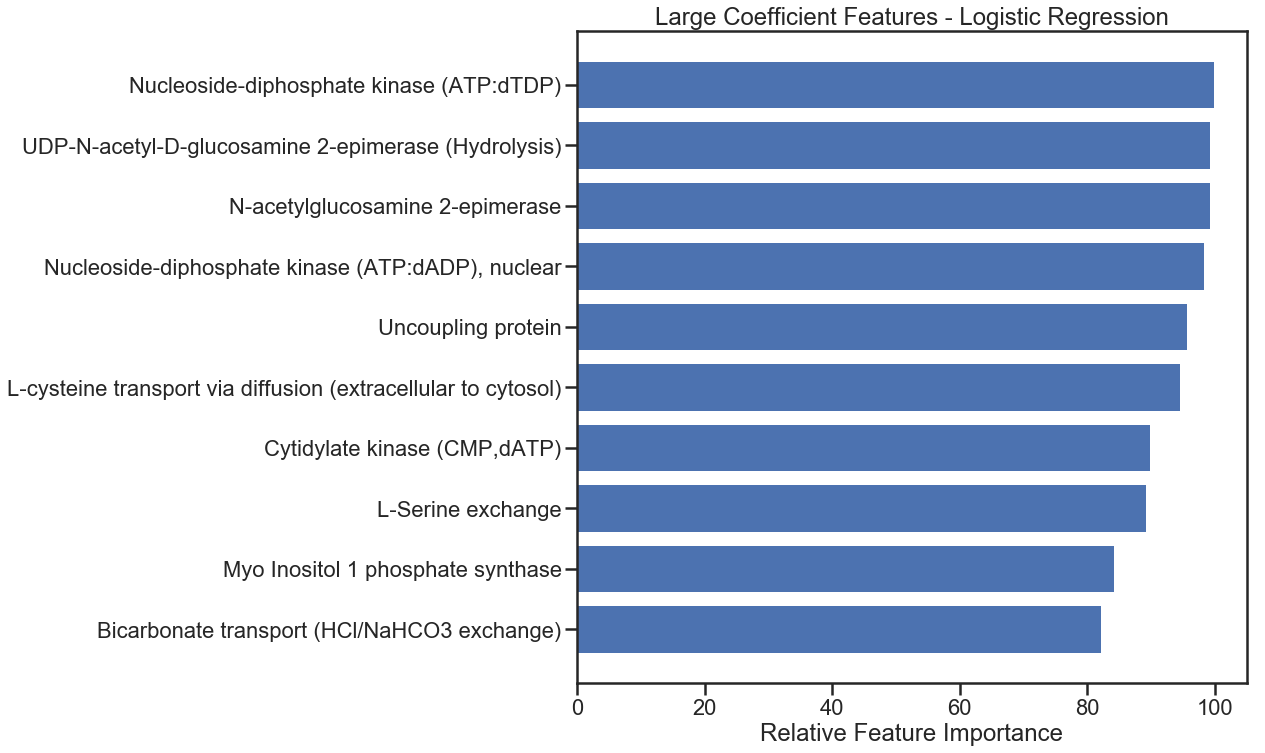

In [0]:
# get top 10 relative feature importances
feature_importance = abs(clf.coef_[0])
plot_top_features(feature_importance, title = 'Large Coefficient Features - Logistic Regression')

In [0]:
# Get feature importances and write to table
sorted_idx = np.argsort(feature_importance)

d = {'feature_name': np.array(X_new.columns)[sorted_idx], 'feature_importance': feature_importance[sorted_idx]}
df = pd.DataFrame(data=d)
df.to_csv('Feature_Importance_BRCA_LogReg.csv')

Normalized confusion matrix
[[0.57 0.43]
 [0.09 0.91]]


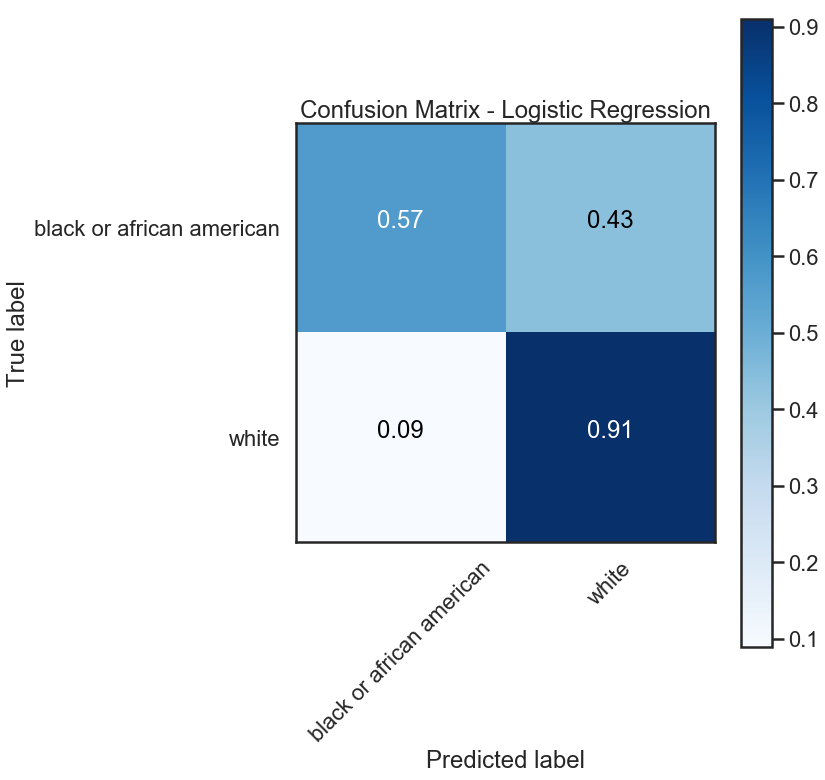

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
sns.set(context = 'poster', style = 'white')
plt.figure(figsize = (12,12))
plot_confusion_matrix(cnf_matrix, classes=le.classes_,normalize=True,
                      title='Confusion Matrix - Logistic Regression')

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

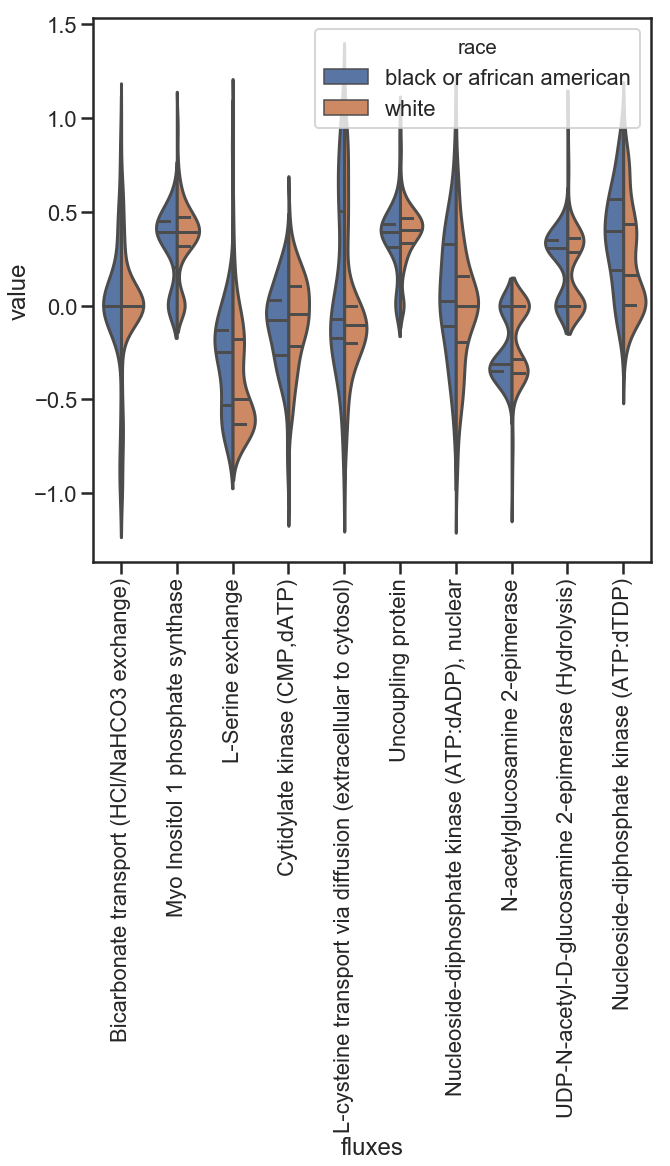

In [0]:
# compare top 10 most important features between groups
top_feat = X_new[X_new.columns[sorted_idx][-10:]]
top_feat['race'] = clin_df_BW.patient_race_list_race.tolist()

# melt top features into long form dataframe
data = pd.melt(top_feat,id_vars='race',
                    var_name="fluxes",
                    value_name='value')

# make violin plots
plt.figure(figsize=(10,10))
sns.violinplot(x="fluxes", y="value", hue="race", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

In [0]:
# Tune SGDClassifier
tuned_parameters = {'max_iter':[10,100,1000], 
                   'alpha':np.logspace(-6, 1, 8),
                   'penalty':['l2', 'elasticnet']}

clf = GridSearchCV(SGDClassifier(), tuned_parameters, cv=5, scoring='roc_auc')

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
y_true, y_pred = y_test, clf.predict(X_test)
print(roc_auc_score(y_true, y_pred))

In [0]:
clf = SGDClassifier(alpha = 0.001, max_iter = 1000, penalty = 'l2')
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)
roc_auc_score(y_true, y_pred)

In [0]:
# get relative feature importances
feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(12,12))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.show()

In [0]:
# get top 10 most important features
top_feat = X[X.columns[sorted_idx][-10:]]
top_feat['race'] = BRCA_clin.patient_race_list_race
top_feat.head()

# melt top features into long form dataframe
data = pd.melt(top_feat,id_vars='race',
                    var_name="fluxes",
                    value_name='value')

# make violin plots
plt.figure(figsize=(10,10))
sns.violinplot(x="fluxes", y="value", hue="race", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

In [0]:
# Try DecisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.4, random_state=42)

tuned_parameters = {'max_features':list(range(1,X_new.shape[1]))}

clf = GridSearchCV(DecisionTreeClassifier(random_state=42, max_depth=8.0), tuned_parameters, cv=5, scoring='roc_auc')             

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
y_true, y_pred = y_test, clf.predict(X_test)
print(roc_auc_score(y_true, y_pred))

Best parameters set found on development set:
{'max_features': 133}
Grid scores on development set:

0.577 (+/-0.161) for {'max_features': 1}
0.650 (+/-0.196) for {'max_features': 2}
0.504 (+/-0.190) for {'max_features': 3}
0.585 (+/-0.174) for {'max_features': 4}
0.523 (+/-0.125) for {'max_features': 5}
0.562 (+/-0.135) for {'max_features': 6}
0.517 (+/-0.112) for {'max_features': 7}
0.522 (+/-0.126) for {'max_features': 8}
0.509 (+/-0.060) for {'max_features': 9}
0.571 (+/-0.137) for {'max_features': 10}
0.555 (+/-0.188) for {'max_features': 11}
0.588 (+/-0.140) for {'max_features': 12}
0.594 (+/-0.304) for {'max_features': 13}
0.600 (+/-0.282) for {'max_features': 14}
0.580 (+/-0.175) for {'max_features': 15}
0.552 (+/-0.147) for {'max_features': 16}
0.597 (+/-0.274) for {'max_features': 17}
0.607 (+/-0.105) for {'max_features': 18}
0.575 (+/-0.246) for {'max_features': 19}
0.593 (+/-0.152) for {'max_features': 20}
0.540 (+/-0.088) for {'max_features': 21}
0.586 (+/-0.178) for {'max

In [0]:
clf = DecisionTreeClassifier(random_state = 42, max_depth = 8.0, max_features = 133)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.4, random_state=42)
clf.fit(X_train, y_train)
y_true, y_pred = y_test, clf.predict(X_test)
roc_auc_score(y_true, y_pred)

0.6885686370297996

(11, 12, 9, 80)

In [0]:
confusion_matrix(y_true, y_pred)

array([[11, 12],
       [ 9, 80]], dtype=int64)

array(['black or african american', 'white'], dtype='<U25')

Normalized confusion matrix
[[0.48 0.52]
 [0.1  0.9 ]]


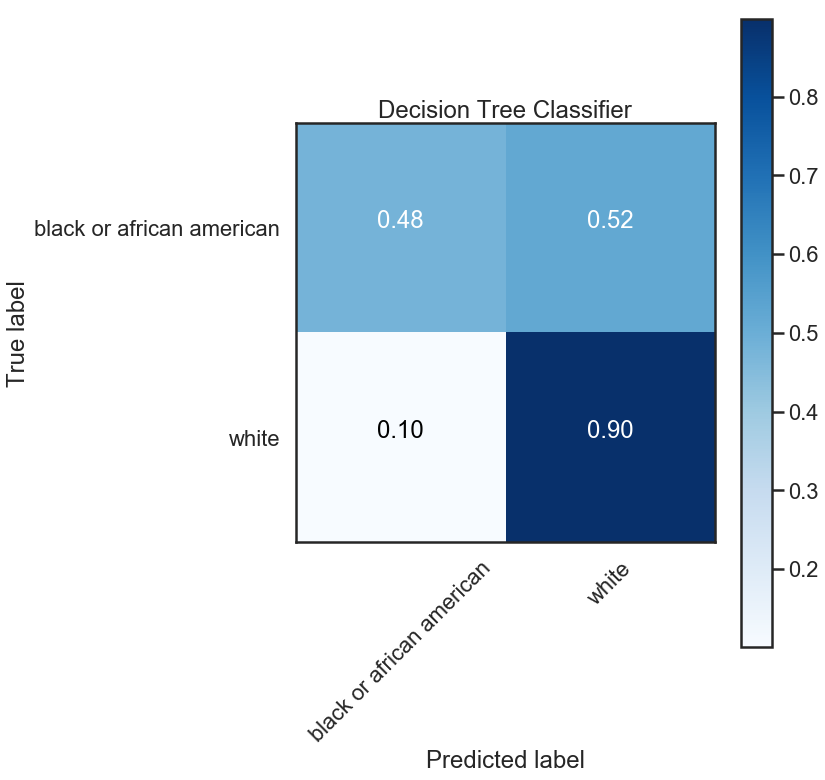

In [0]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

# get confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
sns.set(context = 'poster',
       style = 'white')
plt.figure(figsize = (12,12))
plot_confusion_matrix(cnf_matrix, classes=le.classes_,normalize=True,
                      title='Decision Tree Classifier')